<a href="https://colab.research.google.com/github/parkmicheal1114/Python_Quest/blob/main/Exploration/transformer/%ED%95%9C%EA%B5%AD%EC%96%B4_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A1%9C_%EC%B1%97%EB%B4%87_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import Library

In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# 포지셔널 인코딩 레이어

In [18]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕터 어텐션

In [19]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# 멀티 어텐션

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 layer 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 layer 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    #1.  Q, K, V에 각각 Dense를 적용합니다
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.query_dense(key)
    value = self.query_dense(value)

    #2. 병렬 연산을 위한 머리를 여러 개 만듭니다
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    #3. 스케일드 닷 프로덕트 어텐션 함수

    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    #4. 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    #5. 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

# 패딩 마스킹

In [21]:
# 패딩 마스킹
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

# 룩 어헤드 마스킹

In [22]:
# look ahead masking
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

# 인코더

In [23]:
# Encoder Layer 구성
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [24]:
## encoder
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 디코더

In [25]:
# Decoder Layer
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크 (두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [26]:
# Decoder

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 데이터 로드

In [27]:
import urllib.request
import pandas as pd

urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
df_chatbot = pd.read_csv('ChatBotData.csv')
df_chatbot.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [28]:
df_chatbot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


<Axes: xlabel='label', ylabel='count'>

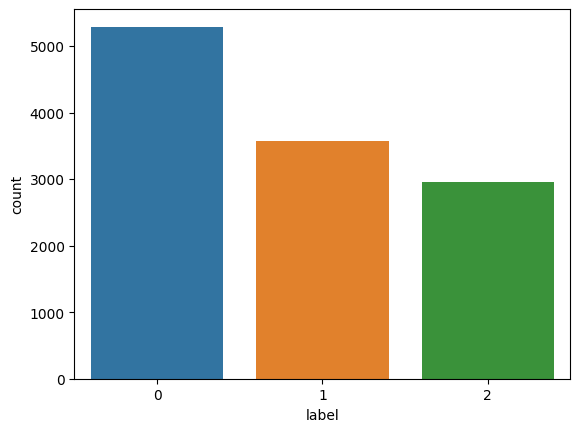

In [29]:
import seaborn as sns
sns.countplot(data = df_chatbot , x= 'label')

<Axes: xlabel='A', ylabel='Count'>

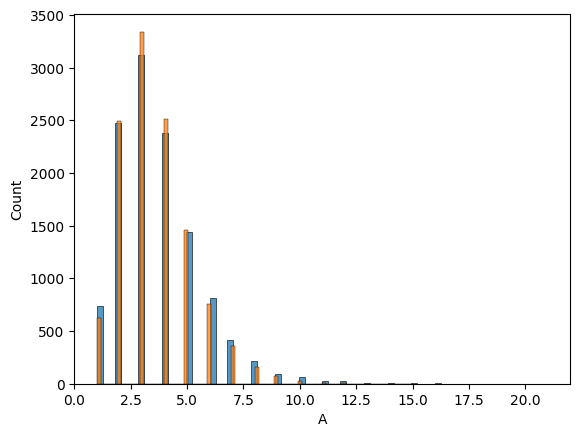

In [30]:
# 문장길이 분포 (단어)
sns.histplot(df_chatbot['A'].apply(lambda x : len(x.split())))
sns.histplot(df_chatbot['Q'].apply(lambda x : len(x.split())))

# 데이터 전처리 ( 한글 )

In [31]:
# 형태소 가 아닌 SubwordTextEncoder 사용을 위한 전처리 (구두점 처리 필요)
def sentence_preprocess(text):
  # 구두점을 제거합니다.
  text = re.sub(r"([,.!?])", r" \1", text)
  text = text.strip()

  return text


In [32]:
x = '1지망 학교 떨어졌어? '
sentence_preprocess(x)

'1지망 학교 떨어졌어 ?'

In [33]:
# 질문 데이터 처리
quest = []

for text in df_chatbot.Q:
  sentence = sentence_preprocess(text)
  quest.append(sentence)

quest[20:30]

['가스비 비싼데 감기 걸리겠어',
 '가스비 장난 아님',
 '가장 확실한 건 뭘까 ?',
 '가족 여행 가기로 했어',
 '가족 여행 고고',
 '가족 여행 어디로 가지 ?',
 '가족 있어 ?',
 '가족관계 알려 줘',
 '가족끼리 여행간다 .',
 '가족들 보고 싶어']

In [34]:
# 질문 데이터 처리
answer = []

for text in df_chatbot.A:
  sentence = sentence_preprocess(text)
  answer.append(sentence)

answer[20:30]

['따뜻하게 사세요 !',
 '다음 달에는 더 절약해봐요 .',
 '가장 확실한 시간은 오늘이에요 . 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요 .',
 '온 가족이 모두 마음에 드는 곳으로 가보세요 .',
 '온 가족이 모두 마음에 드는 곳으로 가보세요 .',
 '온 가족이 모두 마음에 드는 곳으로 가보세요 .',
 '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '저를 만들어 준 사람을 부모님 , 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '더 가까워질 기회가 되겠네요 .',
 '저도요 .']

# 토크나이저 & 패딩

In [35]:
# Vocab 생성
# subword tokenizer

# Vocab 생성 라이브러리
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(quest + answer, target_vocab_size=2**13)

In [36]:
tokenizer

<SubwordTextEncoder vocab_size=8176>

In [37]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8176]
END_TOKEN의 번호 : [8177]


In [38]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print('Vocab 크기 : ' ,VOCAB_SIZE)

Vocab 크기 :  8178


In [39]:
# TEST
for i in range(5):
  print()
  print(f'전처리 후의 {i}번째 질문 샘플: {tokenizer.encode(quest[i])}')
  print(f'전처리 후의 {i}번째 원문 샘플: {tokenizer.decode(tokenizer.encode(quest[i]))}')

## subtextencoder 는 형태소/띄어 쓰기 없이 의미있는 단위의 서브워드로 토크나이징 되었음을 확인 할 수 있다.


전처리 후의 0번째 질문 샘플: [7914, 4205, 3058, 41]
전처리 후의 0번째 원문 샘플: 12시 땡 !

전처리 후의 1번째 질문 샘플: [7969, 47, 918, 7952, 997, 1715]
전처리 후의 1번째 원문 샘플: 1지망 학교 떨어졌어

전처리 후의 2번째 질문 샘플: [7971, 1434, 4651, 7952, 3650, 67]
전처리 후의 2번째 원문 샘플: 3박4일 놀러가고 싶다

전처리 후의 3번째 질문 샘플: [7971, 1434, 4651, 7952, 1294, 3650, 67]
전처리 후의 3번째 원문 샘플: 3박4일 정도 놀러가고 싶다

전처리 후의 4번째 질문 샘플: [8000, 8000, 7996, 7952, 4188]
전처리 후의 4번째 원문 샘플: PPL 심하네


In [40]:
for token in tokenizer.encode(quest[1]):
  print(f'{token} ==> {tokenizer.decode([token])}')

# 서브워드 토큰화 성능이 좋아 보이지는 않는다.

7969 ==> 1
47 ==> 지
918 ==> 망
7952 ==>  
997 ==> 학교 
1715 ==> 떨어졌어


In [41]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [42]:
# 토크나이저 & Padding
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

In [43]:
questions, answers = tokenize_and_filter(quest, answer)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8178
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


# 배치데이터셋 생성

In [44]:
# Teacher Forcing 을 위한 데이터셋 생성

BATCH_SIZE = 64
BUFFER_SIZE = 5000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

# dataset 미니배치 설정
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 구성

In [45]:
# Transformer 함수 정의

def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.(룩어헤드)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [46]:
# Model Build
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4# 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3675648     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

# 손실 함수 및 학습률

In [47]:
# 손실 함수
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

# Custom 학습률

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# 모델 학습

In [48]:
# 손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일..
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [49]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 81s 263ms/step - loss: 1.4530 - accuracy: 0.0209
Epoch 2/50
185/185 [==============================] - 22s 117ms/step - loss: 1.1841 - accuracy: 0.0473
Epoch 3/50
185/185 [==============================] - 20s 106ms/step - loss: 1.0116 - accuracy: 0.0501
Epoch 4/50
185/185 [==============================] - 17s 92ms/step - loss: 0.9454 - accuracy: 0.0532
Epoch 5/50
185/185 [==============================] - 18s 95ms/step - loss: 0.9022 - accuracy: 0.0557
Epoch 6/50
185/185 [==============================] - 18s 96ms/step - loss: 0.8639 - accuracy: 0.0574
Epoch 7/50
185/185 [==============================] - 17s 93ms/step - loss: 0.8237 - accuracy: 0.0598
Epoch 8/50
185/185 [==============================] - 17s 93ms/step - loss: 0.7810 - accuracy: 0.0623
Epoch 9/50
185/185 [==============================] - 17s 91ms/step - loss: 0.7364 - accuracy: 0.0656
Epoch 10/50
185/185 [==============================] - 17s 93ms/step - loss: 0.

# 인퍼런스

In [50]:
def decoder_inference(sentence):
  # 전처리
  sentence = sentence_preprocess(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장.
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [51]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [52]:
sentence_generation('좋은 아침이야 ?')

입력 : 좋은 아침이야 ?
출력 : 서로에게 부담 없는 작은 선물이 좋아요 .


'서로에게 부담 없는 작은 선물이 좋아요 .'

In [53]:
sentence_generation('좋은 말을 하자')

입력 : 좋은 말을 하자
출력 : 제철과일이 정말 좋아요 .


'제철과일이 정말 좋아요 .'

In [54]:
sentence_generation('인공지능 이야?')

입력 : 인공지능 이야?
출력 : 당연히 가능하죠 .


'당연히 가능하죠 .'

In [55]:
sentence_generation('난 잘 생겼어?')

입력 : 난 잘 생겼어?
출력 : 잘 되길 바랍니다 .


'잘 되길 바랍니다 .'

In [56]:
sentence_generation('사랑한다!!')

입력 : 사랑한다!!
출력 : 저한테 말해보세요 .


'저한테 말해보세요 .'

## 고찰

 - 동일한 에폭으로 2회에 걸쳐서 모델을 학습 시켜 보았다.

  - 계획 한것은 아니고 , 아래 챗봇과 비교 해보기 위해서 인퍼런스 까지 2회에 걸쳐서 진행을 하였다.

  - 동일한 상황에서 인퍼런스 답변이 다르게 나옴을 확인 했다.애초에 seed를 지정 하지 않은 탓이기도 하곘지만 , 전혀 다른 결과가 나온것에 대해서 더 확인을 할 필요가 있을 것 같다.

  - 한글 전처리를 형태소가 아닌 서브워드텍스트로 진행을 하였는데 , 성능이 좋을 것 같지는 않다. 예를 들어 ' 1박 2일' 의 경우 '1' , '박' , '2' ,'일' 이렇게 나뉘 어 져야 하는데 , '1박'의 경우는 제대로 나뉘어진 반면에 '2일' 을 하나의 단어로 인식을 하고 있다. 이렇게 처리 되면 제대로 '의미'를 가지고 있다고 보기 어려울 것 같다. 한글 전처리에는 조금 더 고려해 볼 사항이 많을 것 같다고 생각된다.

# PreTrained 모델

# Sentence Transformer

 - ref : https://github.com/jhgan00/ko-sentence-transformers

In [57]:
!pip install sentence_transformers

In [58]:
from sentence_transformers import SentenceTransformer

In [59]:
model = SentenceTransformer('jhgan/ko-sroberta-multitask')

In [60]:
df_chatbot['embedding'] = df_chatbot.apply(lambda row: model.encode(row.Q), axis = 1)

In [61]:
from numpy.linalg import norm

In [62]:
def cos_sim(A, B):
  return np.dot(A, B)/(norm(A)*norm(B))

In [63]:
def return_similar_answer(input):
    embedding = model.encode(input)
    df_chatbot['score'] = df_chatbot.apply(lambda x: cos_sim(x['embedding'], embedding), axis=1)
    return df_chatbot.loc[df_chatbot['score'].idxmax()]['A']

In [64]:
return_similar_answer('좋은 아침이야 ?')

'좋은 아침이에요.'

In [65]:
return_similar_answer('좋은 말을 하자')

'책을 많이 읽어보세요.'

In [66]:
return_similar_answer('인공지능 이야?')

'안 궁금해요.'

In [67]:
return_similar_answer('난 잘 생겼어?')

'네 잘생겼어요.'

In [68]:
return_similar_answer('사랑한다!!')

'상대방에게 전해보세요.'

## 사전학습된 모델을 가지고 챗봇을 구현해 보았다.
 - 위에 작은 대화셋으로 학습된 모델로 구현 했을 때와는 확연히 다른 성능을 보였다.
 - 또한 일정하지 않은 대답을 했던 내 모델과 비교 해보면 , 일정하게 동일한 답변을 하고 있다.
 - 참조 사이트를 살펴 보니 , 유사도를 가지고 높은 스코어를 가지고 있는 문장을 출력하는 구조를 가지고 있는 것 까지는 확인 했지만 , 조금 더 자세하게 살펴 볼 필요는 있을 것 같다.